- 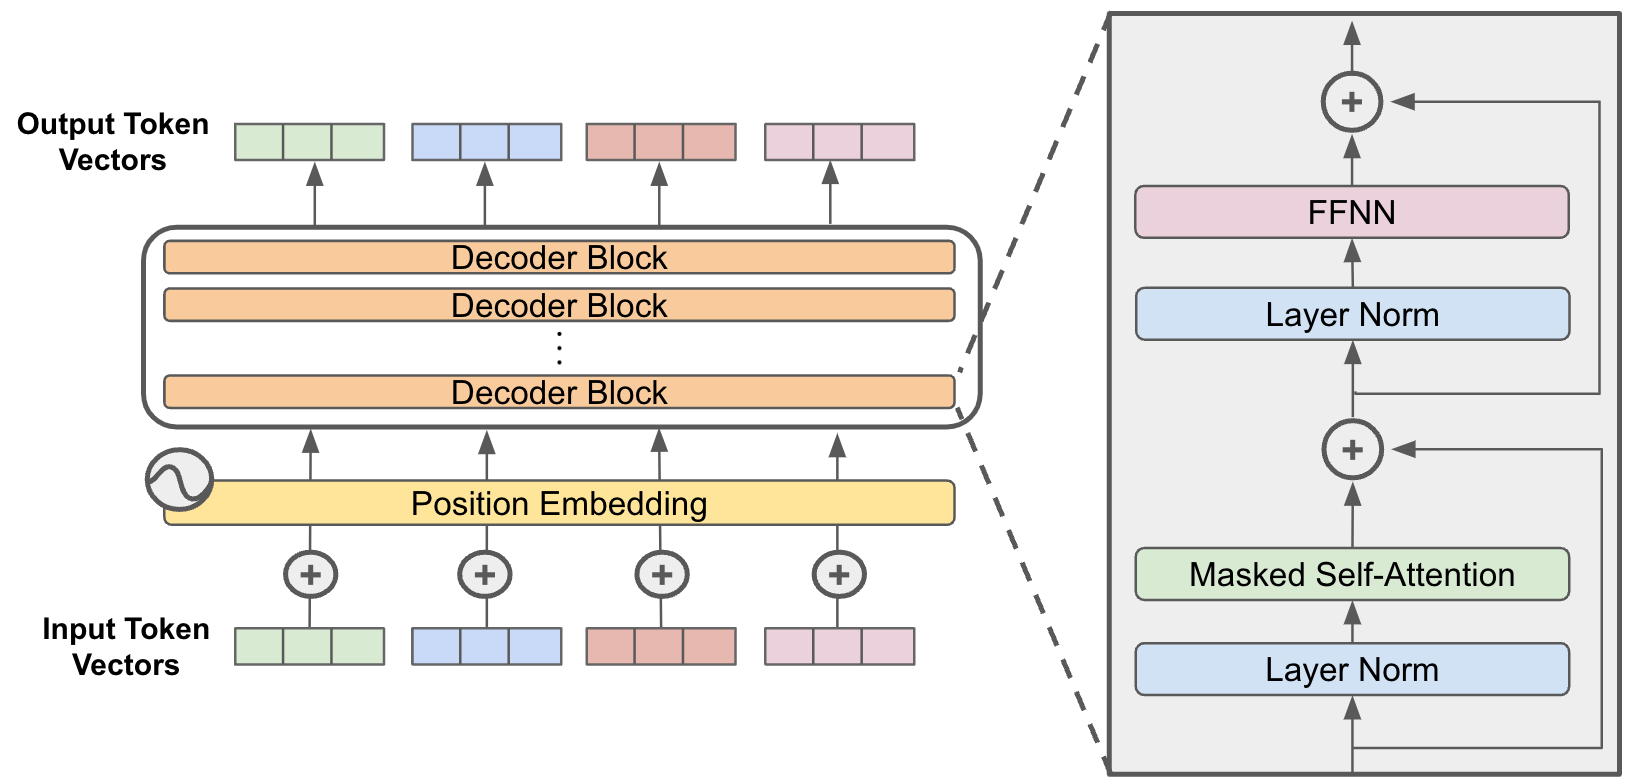
- https://github.com/hkproj/transformer-from-scratch-notes/blob/main/Diagrams_V2.pdf

things to code : <br/>
<input type="checkbox" /> EMBEDDING + POSITIONAL EMBEDDINGS <br/>
<input type="checkbox" />  ATTENTION HEAD <br/>
<input type="checkbox" /> MULTI HEAD ATTENTION <br/>
<input type="checkbox" /> FEED FORWARD <br/>
<input type="checkbox" /> DECODER <br/>
<input type="checkbox" /> TRANSFORMER

In [1]:
import torch 
import torch.nn as nn 
import torch.nn.functional as F

## ATTENTION 
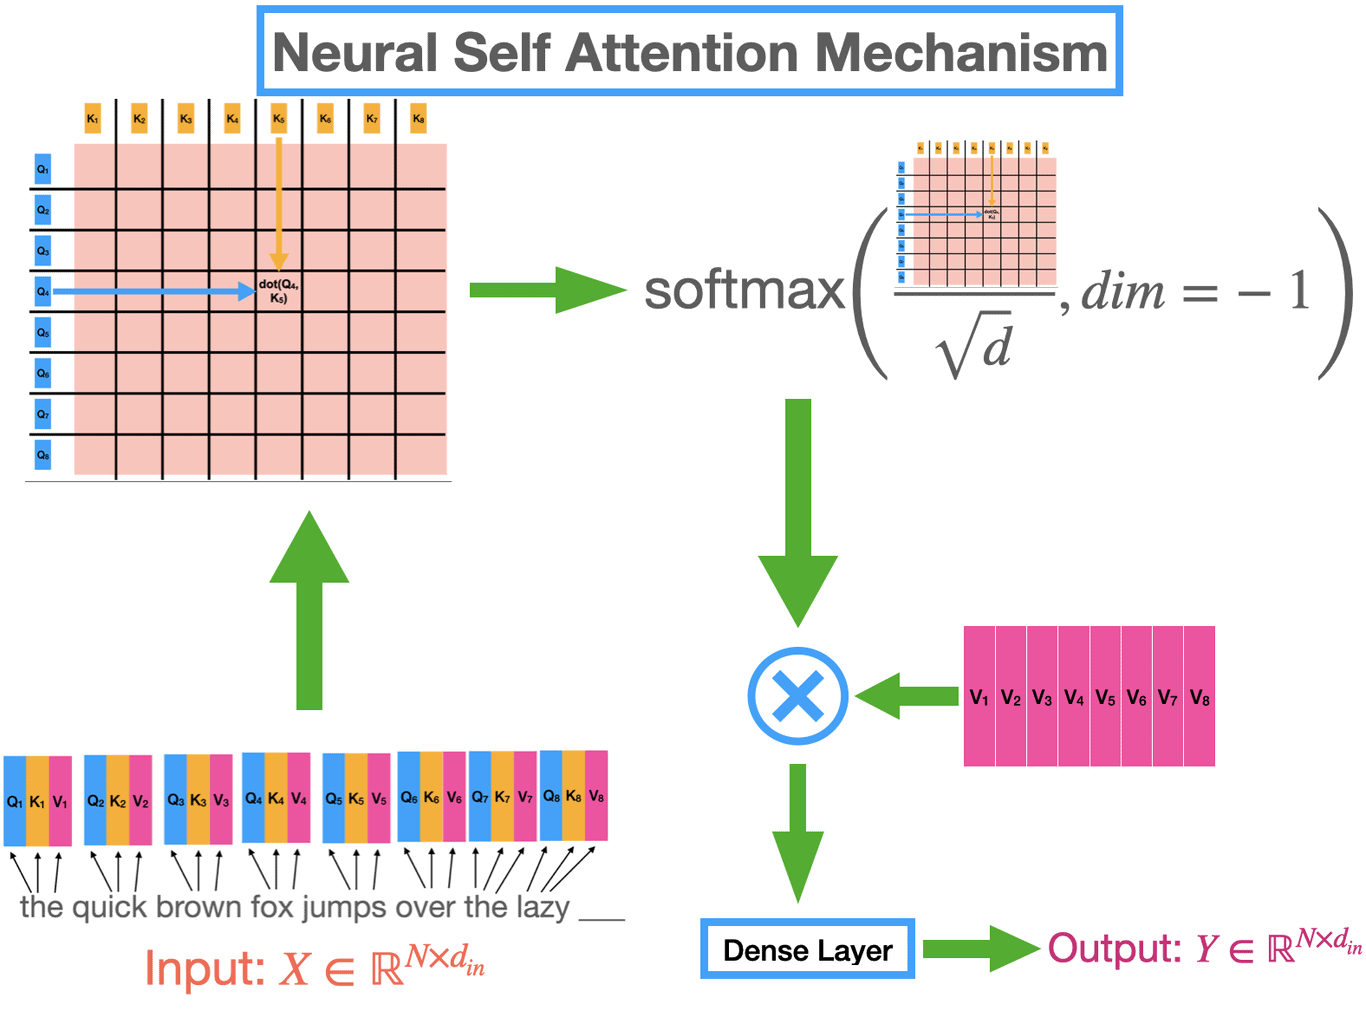


In [3]:
class Head(nn.Module): 
    
    def __init__(self, seq_length, embed_size):
        super().__init__() 
        self.seq_length = seq_length
        self.embed_size = embed_size
        self.w_q = nn.Parameter(torch.randn(seq_length, embed_size))
        self.w_k = nn.Parameter(torch.randn(seq_length, embed_size))
        self.w_v = nn.Parameter(torch.randn(seq_length, embed_size))
        self.w_out = nn.Parameter(torch.randn(seq_length, embed_size)) 
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        q = torch.matmul(x, self.w_q)
        k = torch.matmul(x, self.w_k)
        v = torch.matmul(x, self.w_v)
        attention_scores = torch.matmul(q, k.T) / (self.embed_size ** 0.5) 
        attention_weights = self.softmax(attention_scores) 
        output = torch.matmul(attention_weights, v)
        return torch.matmul(output, self.w_out) 
    

In [4]:
class MultiHeadAttention(nn.Module): 
    def __init__(self, seq_length, embed_size, num_heads): 
        super().__init__() 
        self.seq_length = seq_length
        self.embed_size = embed_size
        self.num_heads = num_heads
        self.heads = nn.ModuleList([Head(seq_length, embed_size) for _ in range(num_heads)])
        self.w_out = nn.Parameter(torch.randn(num_heads * embed_size, embed_size))
        
    def forward(self, x): 
        outputs = [head(x) for head in self.heads]
        combined = torch.cat(outputs, dim=1)
        return torch.matmul(combined, self.w_out)
        

In [5]:
class FeedForwardLayer(nn.Module):

    def __init__(self, n_embd, dropout=0.1):
        super().__init__()
        self.ffwd = nn.Sequential(
            nn.Linear(n_embd, 4*n_embd),
            nn.ReLU(),
            nn.Linear(4*n_embd, n_embd),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.ffwd(x)

In [ ]:
class Block(nn.Module):

    def __init__(self, num_heads, head_size):
        super().__init__()
        head_size = n_embd // n_head
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)
        self.attn = MultiHeadAttention(num_heads, head_size)
        self.ffwd = FeedForwardLayer(n_embd)

    def forward(self, x):
        x = x + self.attn(self.ln1(x)) # residual connection
        x = x + self.ffwd(self.ln2(x)) # residual connection
        return x # B, T, C

In [6]:
class DecoderTransformer(nn.Module):
    def __init__(self, n_embd, n_head, n_layer, vocab_size):
        super().__init__()
        
        self.n_embd = n_embd
        self.n_head = n_head
        self.n_layer = n_layer
        self.vocab_size = vocab_size
        
        self.token_embedding = nn.Embedding(vocab_size, n_embd)
        self.position_embedding = nn.Embedding(1024, n_embd)
        self.blocks = nn.ModuleList([Block(n_embd, n_head) for _ in range(n_layer)])
        self.ln = nn.LayerNorm(n_embd)
        self.linear = nn.Linear(n_embd, vocab_size)
        
    def forward(self, x):
        x = self.token_embedding(x) + self.position_embedding(x)
        for block in self.blocks:
            x = block(x)
        x = self.ln(x)
        x = self.linear(x)
        return x

above code is incorrect!!!!

In [7]:
import torch
import torch.nn as nn
import math

class Head(nn.Module):
    """Single attention head"""
    def __init__(self, embed_size, head_size):
        super().__init__()
        self.q_proj = nn.Linear(embed_size, head_size, bias=False)
        self.k_proj = nn.Linear(embed_size, head_size, bias=False)
        self.v_proj = nn.Linear(embed_size, head_size, bias=False)
        self.dropout = nn.Dropout(0.1)
        
    def forward(self, x):
        B, T, C = x.shape
        
        q = self.q_proj(x)  # (B, T, head_size)
        k = self.k_proj(x)  # (B, T, head_size)
        v = self.v_proj(x)  # (B, T, head_size)
        
        # Compute attention scores
        attn_scores = q @ k.transpose(-2, -1) / math.sqrt(k.size(-1))  # (B, T, T)
        attn_weights = torch.softmax(attn_scores, dim=-1)  # (B, T, T)
        attn_weights = self.dropout(attn_weights)
        
        # Weighted sum of values
        out = attn_weights @ v  # (B, T, head_size)
        return out

class MultiHeadAttention(nn.Module):
    """Multiple attention heads"""
    def __init__(self, embed_size, num_heads):
        super().__init__()
        head_size = embed_size // num_heads
        self.heads = nn.ModuleList([Head(embed_size, head_size) for _ in range(num_heads)])
        self.out_proj = nn.Linear(embed_size, embed_size)  # project concatenated heads back
    
    def forward(self, x):
        out = torch.cat([head(x) for head in self.heads], dim=-1)  # concat along feature dim
        out = self.out_proj(out)
        return out

class FeedForward(nn.Module):
    """Feedforward layer"""
    def __init__(self, embed_size):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(embed_size, 4 * embed_size),
            nn.ReLU(),
            nn.Linear(4 * embed_size, embed_size),
            nn.Dropout(0.1)
        )
    
    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """Transformer block: communication followed by computation"""
    def __init__(self, embed_size, num_heads):
        super().__init__()
        self.ln1 = nn.LayerNorm(embed_size)
        self.ln2 = nn.LayerNorm(embed_size)
        self.attn = MultiHeadAttention(embed_size, num_heads)
        self.ffwd = FeedForward(embed_size)
    
    def forward(self, x):
        x = x + self.attn(self.ln1(x))  # residual connection
        x = x + self.ffwd(self.ln2(x))  # residual connection
        return x

class DecoderTransformer(nn.Module):
    """Minimal decoder-only Transformer"""
    def __init__(self, vocab_size, embed_size, num_layers, num_heads, max_seq_len):
        super().__init__()
        self.token_embed = nn.Embedding(vocab_size, embed_size)
        self.position_embed = nn.Embedding(max_seq_len, embed_size)
        self.blocks = nn.Sequential(*[Block(embed_size, num_heads) for _ in range(num_layers)])
        self.ln_f = nn.LayerNorm(embed_size)
        self.head = nn.Linear(embed_size, vocab_size)
    
    def forward(self, idx):
        B, T = idx.shape
        token_embeddings = self.token_embed(idx)  # (B, T, embed_size)
        position_embeddings = self.position_embed(torch.arange(T, device=idx.device))  # (T, embed_size)
        x = token_embeddings + position_embeddings.unsqueeze(0)  # (B, T, embed_size)
        x = self.blocks(x)
        x = self.ln_f(x)
        logits = self.head(x)  # (B, T, vocab_size)
        return logits

In [8]:
model = DecoderTransformer(
    vocab_size=5000,
    embed_size=512,
    num_layers=6,
    num_heads=8,
    max_seq_len=1024
)